In [2]:
# reload packages
%load_ext autoreload
%autoreload 2`

### Choose GPU

In [3]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [4]:
import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if len(gpu_devices)>0:
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
print(gpu_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
tf.keras.backend.clear_session()

### dataset information

In [6]:
from datetime import datetime

dataset = "mnist"
dims = (28, 28, 1)
umap_prop = 0.0
num_classes = 10
PROJECTION_DIMS = 1024
labels_per_class = 1024  # 'full'
datestring = datetime.now().strftime("%Y_%m_%d_%H_%M_%S_%f")
datestring = (
    str(dataset)
    + "_"
    + str(umap_prop)
    + "_"
    + str(PROJECTION_DIMS)
    + "_"
    + str(labels_per_class)
    + "____"
    + datestring
    + '__linear-umap-euclidean'
)
print(datestring)

mnist_0.0_1024_64____2020_08_07_22_41_28_480682__linear-umap-euclidean


### Load packages

In [7]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
from IPython import display
import pandas as pd
import umap
import copy
import os, tempfile

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


### Load dataset

In [8]:
from tfumap.load_datasets import load_MNIST, mask_labels

In [9]:
X_train, X_test, X_valid, Y_train, Y_test, Y_valid = load_MNIST(flatten=False)
X_train.shape

(50000, 28, 28, 1)

In [10]:
if labels_per_class == "full":
    X_labeled = X_train
    Y_masked = Y_labeled = Y_train
else:
    X_labeled, Y_labeled, Y_masked = mask_labels(
        X_train, Y_train, labels_per_class=labels_per_class
    )

### Build umap graph

In [11]:
from tfumap.semisupervised import build_fuzzy_simplicial_set

In [12]:
n_neighbors = 15  # default = 15
umap_graph = build_fuzzy_simplicial_set(
    X_train.reshape((len(X_train), np.product(np.shape(X_train)[1:]))),
    y=Y_masked,
    n_neighbors=n_neighbors,
)

### Build data iterators

In [13]:
from tfumap.umap import compute_cross_entropy, get_graph_elements
from tfumap.semisupervised import create_edge_iterator, create_validation_iterator, create_classification_iterator

In [14]:
n_epochs = 200
graph, epochs_per_sample, head, tail, weight, n_vertices = get_graph_elements(
            umap_graph, n_epochs
)
batch_size = np.min([n_vertices, 1000])
batch_size

1000

In [15]:
# make sure batch size is no bigger than the number of labels per class
labeled_batch_size = batch_size if batch_size < len(Y_labeled) else len(Y_labeled)
labeled_iter = create_classification_iterator(X_labeled, Y_labeled, batch_size=batch_size)
print(labeled_batch_size)

640


In [16]:
max_sample_repeats_per_epoch = 25
edge_iter, n_edges_per_epoch = create_edge_iterator(
    head,
    tail,
    weight,
    batch_size=batch_size,
    max_sample_repeats_per_epoch=max_sample_repeats_per_epoch,
)

In [17]:
data_valid, n_valid_samp = create_validation_iterator(X_valid, Y_valid, batch_size, repeat=True)

### Build network

In [18]:
encoder = tf.keras.Sequential()
encoder.add(tf.keras.layers.InputLayer(input_shape=dims))
encoder.add(tf.keras.layers.Conv2D(
    filters=32, kernel_size=3, strides=1, padding="same", activation="relu"
))
encoder.add(tf.keras.layers.Conv2D(
    filters=64, kernel_size=3, strides=1, padding="same", activation="relu"
))
encoder.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
encoder.add(tf.keras.layers.Dropout(0.25))
encoder.add(tf.keras.layers.Flatten())
encoder.add(tf.keras.layers.Dense(units=128, activation="relu"))
encoder.add(tf.keras.layers.Dropout(0.25))

In [19]:
classifier = tf.keras.Sequential()
classifier.add(tf.keras.layers.InputLayer(input_shape=128))
classifier.add(tf.keras.layers.Dense(units=128, activation="relu"))
classifier.add(tf.keras.layers.Dense(units=128, activation="relu"))
classifier.add(tf.keras.layers.Dense(num_classes, activation='softmax', name="predictions"))

In [20]:
encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               1605760   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

### Create UMAP object

In [21]:
from tfumap.semisupervised_model import PUMAP, compute_classifier_loss

In [22]:
def compute_umap_loss(
    batch_to,
    batch_from,
    encoder,
    _a,
    _b,
    negative_sample_rate=5,
    repulsion_strength=1,
):
    """
        compute the cross entropy loss for learning embeddings

        Parameters
        ----------
        batch_to : tf.int or tf.float32
            Either X or the index locations of the embeddings for verticies (to)
        batch_from : tf.int or tf.float32
            Either X or the index locations of the embeddings for verticies (from)

        Returns
        -------
        ce_loss : tf.float
            cross entropy loss for UMAP
        embedding_to : tf.float
            embeddings for verticies (to)
        embedding_from : tf.float
            embeddings for verticies (from)
        """

    # encode
    embedding_to = encoder(batch_to)
    embedding_from = encoder(batch_from)

    # get negative samples
    embedding_neg_to = tf.repeat(embedding_to, negative_sample_rate, axis=0)
    repeat_neg = tf.repeat(embedding_from, negative_sample_rate, axis=0)
    embedding_neg_from = tf.gather(
        repeat_neg, tf.random.shuffle(tf.range(tf.shape(repeat_neg)[0]))
    )

    #  distances between samples
    distance_embedding = tf.concat(
        [
            tf.norm(embedding_to - embedding_from, axis=1),
            tf.norm(embedding_neg_to - embedding_neg_from, axis=1),
        ],
        axis=0,
    )

    # convert probabilities to distances
    probabilities_distance = convert_distance_to_probability(distance_embedding, _a, _b)

    # treat positive samples as p=1, and negative samples as p=0
    probabilities_graph = tf.concat(
        [tf.ones(embedding_to.shape[0]), tf.zeros(embedding_neg_to.shape[0])], axis=0,
    )

    # cross entropy loss
    (attraction_loss, repellant_loss, ce_loss) = compute_cross_entropy(
        probabilities_graph,
        probabilities_distance,
        repulsion_strength=repulsion_strength,
    )

    return (
        attraction_loss,
        repellant_loss,
        ce_loss,
    )


In [23]:
import tensorflow as tf
from tfumap.umap import compute_cross_entropy, convert_distance_to_probability
from tfumap.semisupervised import (
    find_a_b,
    #compute_umap_loss,
    # compute_classifier_loss,
    batch_data,
)
import numpy as np
import os, tempfile
from tqdm.autonotebook import tqdm
from datetime import datetime


@tf.function
def compute_classifier_loss(X, y, encoder, classifier, sparse_ce, acc_func):
    """ compute the cross entropy loss for classification
        """
    d = classifier(encoder(X))
    loss = sparse_ce(y, d)
    acc = acc_func(y, d)
    #acc = tf.keras.metrics.sparse_categorical_accuracy(y, d)
    return loss, acc


class PUMAP(tf.keras.Model):
    def __init__(
        self,
        encoder,
        classifier,
        tensorboard_logdir=None,  # directory for tensorboard log
        min_dist=0.1,
        negative_sample_rate=5.0,
        optimizer=tf.keras.optimizers.SGD(0.1),
        repulsion_strength=1.0,
        # ** kwargs,
    ):
        super(PUMAP, self).__init__()
        # self.__dict__.update(kwargs)

        # subnetworks
        self.encoder = encoder
        self.classifier = classifier


        # optimizer for cross entropy minimization
        self.optimizer = optimizer
        self.repulsion_strength = repulsion_strength
        self.negative_sample_rate = negative_sample_rate

        # get a,b for current min_dist
        self._a, self._b = find_a_b(min_dist)

        # create summary writer to log loss information during training
        if tensorboard_logdir is None:
            self.tensorboard_logdir = os.path.join(
                tempfile.gettempdir(),
                "tensorboard",
                datetime.now().strftime("%Y%m%d-%H%M%S"),
            )
        else:
            self.tensorboard_logdir = tensorboard_logdir
        self.summary_writer_train = tf.summary.create_file_writer(
            self.tensorboard_logdir + "/train"
        )
        self.summary_writer_valid = tf.summary.create_file_writer(
            self.tensorboard_logdir + "/valid"
        )

        # sparse categorical cross entropy
        self.sparse_ce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        self.class_acc = tf.keras.metrics.SparseCategoricalAccuracy()
        self.class_acc_val = tf.keras.metrics.SparseCategoricalAccuracy()

        # self.create_summary_metrics()

    @tf.function
    def train(self, batch_to, batch_from, X, y, umap_prop = 1.0, save_loss=False):
        """ One training step 
        Input are points and weights for positive and negative 
        samples for training. 
            
        """
        if umap_prop > 0:
            with tf.GradientTape() as tape:

                (attraction_loss, repellant_loss, umap_loss) = compute_umap_loss(
                    batch_to,
                    batch_from,
                    self.encoder,
                    self._a,
                    self._b,
                    self.negative_sample_rate,
                    self.repulsion_strength,
                )
            
                classifier_loss, classifier_acc = compute_classifier_loss(
                    X, y, self.encoder, self.classifier, self.sparse_ce, self.class_acc
                )
                loss = (
                    tf.reduce_mean(classifier_loss)
                    + tf.reduce_mean(umap_loss) * umap_prop
                )

            train_vars = (
                self.encoder.trainable_variables
                + self.classifier.trainable_variables
            )
        else:  # ignore running costly UMAP computations if not training on UMAP loss
            with tf.GradientTape() as tape:
                classifier_loss, classifier_acc = compute_classifier_loss(
                    X, y, self.encoder, self.classifier, self.sparse_ce, self.class_acc
                )
                loss = classifier_loss
            train_vars = (
                self.encoder.trainable_variables + self.classifier.trainable_variables
            )
            attraction_loss = repellant_loss = umap_loss = 0

        # compute gradient for umap
        grad = tape.gradient(loss, train_vars)

        # gradients are cliped in UMAP implementation. Any effect here?
        grad = [tf.clip_by_value(grad, -4.0, 4.0) for grad in grad]

        self.optimizer.apply_gradients(zip(grad, train_vars))

        return (
            attraction_loss,
            repellant_loss,
            tf.reduce_mean(umap_loss),
            classifier_loss,
            classifier_acc,
        )

    @tf.function
    def write_losses(
        self,
        step,
        classifier_acc,
        classifier_loss,
        umap_loss,
        classifier_loss_val,
        classifier_acc_val,
    ):
        # write train loss
        with self.summary_writer_train.as_default():
            tf.summary.scalar(
                "classif_acc", classifier_acc, step=step,
            )
            tf.summary.scalar(
                "classif_loss", classifier_loss, step=step,
            )
            tf.summary.scalar(
                "umap_loss", umap_loss, step=step,
            )
            self.summary_writer_train.flush()
        # write valid loss
        with self.summary_writer_valid.as_default():
            tf.summary.scalar(
                "classif_acc", classifier_acc_val, step=step,
            )
            tf.summary.scalar(
                "classif_loss", classifier_loss_val, step=step,
            )
            self.summary_writer_valid.flush()



In [24]:
### Initialize model
model = PUMAP(
    min_dist = 0.0,
    negative_sample_rate = 5, # how many negative samples per positive
    optimizer=tf.keras.optimizers.Adam(1e-3), # cross-entropy optimizer
    encoder=encoder,
    classifier=classifier,    
)

### plotting results

In [27]:
def model_data(X, batch_size, model):
    """ embed a set of points in X to Z
    """
    n_batch = int(np.ceil(len(X) / batch_size))
    return np.vstack(
        [
                model(np.array(X[(i) * batch_size : (i + 1) * batch_size, :]))
            for i in tqdm(range(n_batch), leave=False)
        ]
    )

In [30]:
from tfumap.umap import retrieve_tensors
from sklearn.decomposition import PCA
import seaborn as sns
from umap import UMAP 

def plot_umap_classif_results(
    model,
    X_valid,
    Y_valid,
    X_train,
    X_labeled,
    Y_labeled,
    batch_size,
    dralg = PCA, #umap
    cmap="coolwarm",
    cmap2="bwr",
):
    # get loss dataframe from tensorboard
    try:
        loss_df = retrieve_tensors(model.tensorboard_logdir)
        losses_exist = True
    except ValueError as e:
        print(e)
        losses_exist = False

    pred_model = tf.keras.models.Model(model.classifier.input,[model.classifier.get_layer(name="dense_1").get_output_at(0)])

    # embed data
    enc_valid = model_data(X_valid, batch_size, model.encoder)
    class_valid = model_data(enc_valid, batch_size, pred_model)
    pred_valid = model_data(enc_valid, batch_size, model.classifier)

    enc_lab = model_data(X_labeled, batch_size, model.encoder)
    class_lab = model_data(enc_lab, batch_size, pred_model)
    pred_lab = model_data(enc_lab, batch_size, model.classifier)

    # get classifications and correctness
    classifications_valid = np.argmax(pred_valid, axis=1)
    correctness_valid = classifications_valid == Y_valid

    classifications_lab = np.argmax(pred_lab, axis=1)
    correctness_lab = classifications_lab == np.array(Y_labeled)

    confidence_lab  = np.max(pred_lab, axis=1)
    confidence_valid = np.max(pred_valid, axis=1)

    thresh = 0.0 #0.8
    mask_valid = confidence_valid > thresh
    mask_lab = confidence_lab > thresh

    # embed into 2D 
    dr = dralg()
    enc_valid_2 = dr.fit_transform(enc_valid[mask_valid])
    enc_lab_2 = dr.transform(enc_lab[mask_lab])



    dr = dralg()
    class_valid_2 = dr.fit_transform(class_valid[mask_valid])
    class_lab_2 = dr.transform(class_lab[mask_lab])
    
    fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(14, 6), gridspec_kw = {'wspace':0, 'hspace':0})
    for row, (z_val, z_lab, z_title) in enumerate([
        [enc_valid_2, enc_lab_2, 'encoder'], 
        [class_valid_2, class_lab_2, 'last_layer_classifier'], 

    ]):
        for col, (y_valid, y_labeled, label_name) in enumerate([
            [Y_valid, Y_labeled, 'ground_truth'],
            [classifications_valid, classifications_lab, 'predictions'],
            [correctness_valid, correctness_lab, 'correctness'],
            [confidence_valid, confidence_lab, 'confidence'],
        ]):
            ax = axs[row, col]
            #ax.axis('off')
            if col == 0:
                ax.set_ylabel(z_title)
            if row == 0:
                ax.set_title(label_name)
            #ax.set_title(z_title + '_' + label_name)
            ax.scatter(
                z_val[:, 0],
                z_val[:, 1],
                c=y_valid[mask_valid],
                cmap=cmap if label_name not in ["correctness", "confidence"]  else 'viridis',  # "tab10"
                s=2,
                alpha=0.25,
                rasterized=True,
            )
            if False:
                ax.scatter(
                    z_lab[:, 0],
                    z_lab[:, 1],
                    c=y_labeled[mask_lab],
                    cmap=cmap if label_name not in ["correctness", "confidence"] else 'viridis',  # "tab10"
                    s=20,
                    alpha=0.25,
                    rasterized=True,
                )
            ax.set_xticks([])
            ax.set_yticks([])
        
    plt.show()
    
    fig, axs = plt.subplots(ncols=3, figsize=(14,2))
    if losses_exist:
        ax = axs[0]
        sns.lineplot(
            x="step",
            y="val",
            hue="group",
            data=loss_df[loss_df.variable == "umap_loss"],
            ci=None,
            legend=None,
            ax=ax,
        )
        ax.legend(loc="upper right")
        ax.set_xscale("log")
        ax.set_title("UMAP loss", fontsize=24)
        ax.set_ylabel("Cross Entropy")
        
        ax = axs[1]
        sns.lineplot(
            x="step",
            y="val",
            hue="group",
            data=loss_df[loss_df.variable == "classif_loss"],
            ci=None,
            legend=None,
            ax=ax,
        )
        ax.set_xscale("log")
        ax.legend(loc="upper right")
        # ax.set_yscale("log")
        ax.set_title("Classif loss", fontsize=24)
        ax.set_ylabel("Cross Entropy")
        
        ax = axs[2]
        sns.lineplot(
            x="step",
            y="val",
            hue="group",
            data=loss_df[loss_df.variable == "classif_acc"],
            ci=None,
            legend=None,
            ax=ax,
        )
        ax.set_xscale("log")
        ax.legend(loc="lower right")
        ax.set_title("Classif acc", fontsize=24)
        ax.set_ylabel("Acc")
    plt.show()

No objects to concatenate


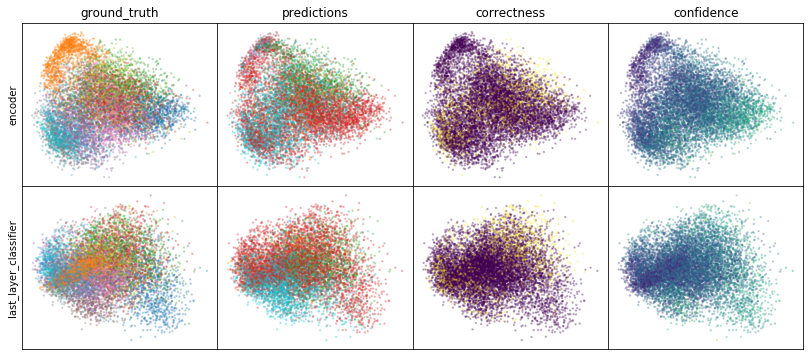

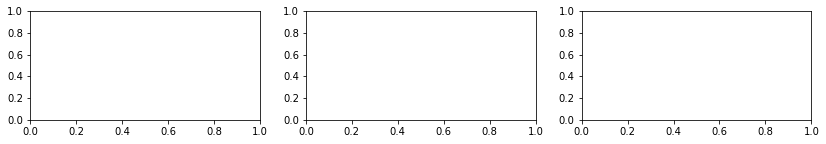

In [31]:
plot_umap_classif_results(model, X_valid, Y_valid, X_train, X_labeled, Y_labeled, batch_size, dralg=PCA, cmap='tab10', cmap2='tab10')

### Train model

In [32]:
N_EPOCHS = 50
n_neighbors=15
batch_size = 256 # 500
max_sample_repeats_per_epoch = 25
max_save_delta = 0.005

In [33]:
from tfumap.semisupervised import build_fuzzy_simplicial_set

In [34]:
from tfumap.paths import MODEL_DIR

In [35]:
# where to save checkpoints
cpt_path = MODEL_DIR / 'semisupervised' / dataset / datestring

In [40]:
BATCHES_PER_EPOCH = int(n_edges_per_epoch / batch_size)

In [36]:
patience = 10000 # wait this many batches without improvement before early stopping
min_delta = 0.0001 # threshold for what counts as an improvement
best_acc = 0 # the best current accuracy score
best_saved_acc = 0 # best accuracy on valid data that has been checkpointed
best_saved_batch = 0 # batch number for last good batch
max_reinitialize_delta = .01 # minimum loss in accuracy resulting in reinitialized weights
plot_frequency = 1000 # how frequently to plot
max_reloads = 10 # how often can we reload weights?
batch = 0; epoch = 0
batches_since_last_reload = 0

In [38]:
epochs_without_improvement = 0
max_epochs_without_improvement = 5 # allow the network 
reload_tolerance = 100 # allow the network at least reload_tolerance batches before reloading last weights

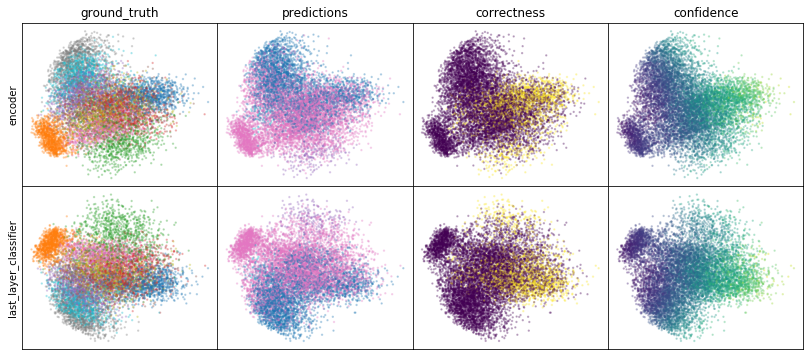

W0807 22:45:48.735322 140282478032640 legend.py:1282] No handles with labels found to put in legend.
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:118: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:132: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
W0807 22:45:48.806101 140282478032640 legend.py:1282] No handles with labels found to put in legend.
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:148: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
W0807 22:45:48.861152 140282478032640 legend.py:1282] No handles with labels found to put in legend.


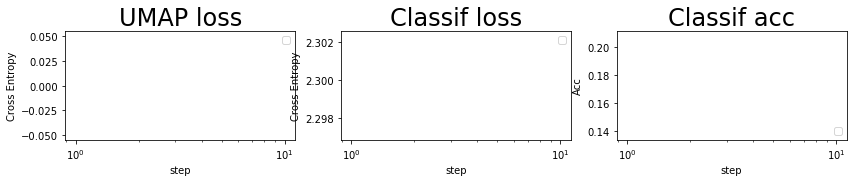

batch: 0 | train acc: 0.137 | val acc: 0.208
saving weights | batch = 100 | acc = 79.868
saving weights | batch = 108 | acc = 80.402
saving weights | batch = 118 | acc = 80.964
saving weights | batch = 129 | acc = 81.512
saving weights | batch = 145 | acc = 82.018
saving weights | batch = 161 | acc = 82.522
saving weights | batch = 185 | acc = 83.023
saving weights | batch = 214 | acc = 83.525
saving weights | batch = 254 | acc = 84.03
saving weights | batch = 298 | acc = 84.543
saving weights | batch = 357 | acc = 85.049
saving weights | batch = 441 | acc = 85.55
saving weights | batch = 587 | acc = 86.051
saving weights | batch = 868 | acc = 86.555


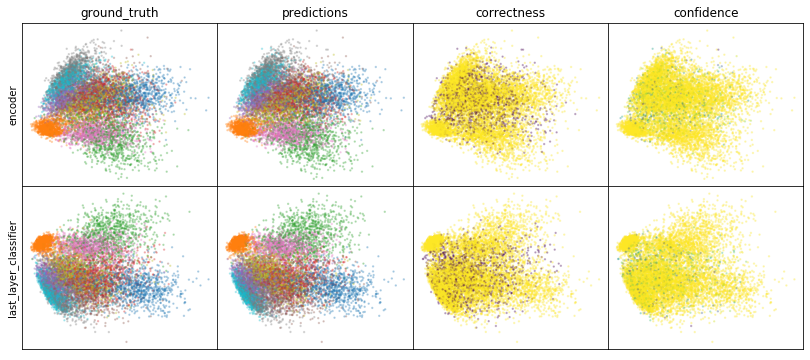

W0807 22:47:45.478687 140282478032640 legend.py:1282] No handles with labels found to put in legend.
W0807 22:47:45.535734 140282478032640 legend.py:1282] No handles with labels found to put in legend.
W0807 22:47:45.591197 140282478032640 legend.py:1282] No handles with labels found to put in legend.


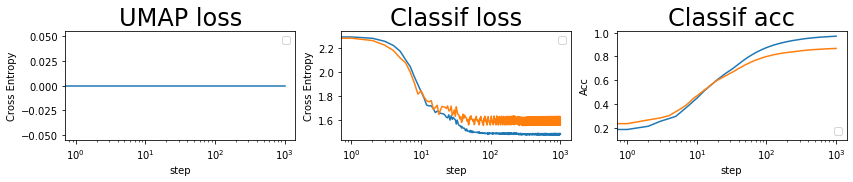

batch: 1000 | train acc: 0.9697 | val acc: 0.8669
saving weights | batch = 1506 | acc = 87.056
saving weights | batch = 1894 | acc = 87.557


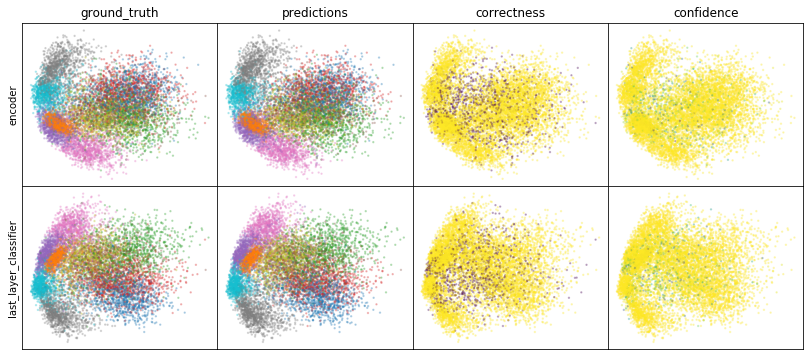

W0807 22:49:40.751037 140282478032640 legend.py:1282] No handles with labels found to put in legend.
W0807 22:49:40.810164 140282478032640 legend.py:1282] No handles with labels found to put in legend.
W0807 22:49:40.871321 140282478032640 legend.py:1282] No handles with labels found to put in legend.


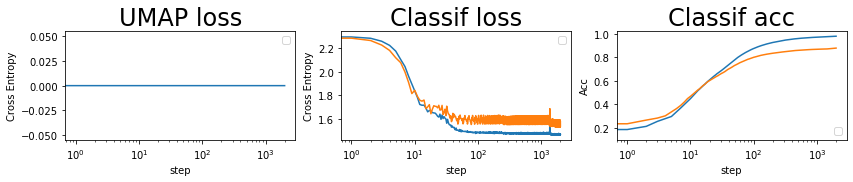

batch: 2000 | train acc: 0.9778 | val acc: 0.8767
saving weights | batch = 2465 | acc = 88.057


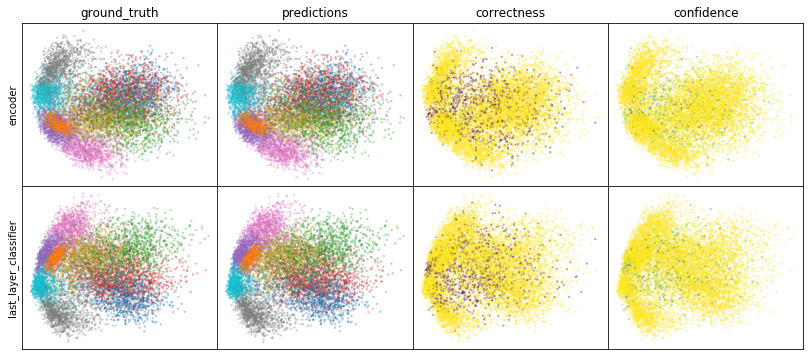

W0807 22:51:36.418659 140282478032640 legend.py:1282] No handles with labels found to put in legend.
W0807 22:51:36.481116 140282478032640 legend.py:1282] No handles with labels found to put in legend.
W0807 22:51:36.543647 140282478032640 legend.py:1282] No handles with labels found to put in legend.


In [ ]:
improved_this_epoch = True
for edge_epoch, epoch in tqdm(
    zip(edge_iter, np.arange(N_EPOCHS)), total=N_EPOCHS, desc="epoch"
):

    pbar = tqdm(total=BATCHES_PER_EPOCH, leave=False, desc="loss")

    for (batch_to, batch_from), (X, y), (X_val, y_val) in zip(
        edge_epoch, labeled_iter, data_valid
    ):

        # train
        (
            attraction_loss,
            repellant_loss,
            umap_loss,
            classifier_loss,
            classifier_acc,
        ) = model.train(
            batch_to=X_train[np.array(batch_to)],
            batch_from=X_train[np.array(batch_from)],
            X=X,
            y=y,
            umap_prop=umap_prop,
        )

        # compute validation loss
        val_loss, val_acc = compute_classifier_loss(
            X_val,
            y_val,
            model.encoder,
            model.classifier,
            model.sparse_ce,
            model.class_acc_val,
        )

        pbar.update()
        pbar.set_description("val acc: {}".format(str(round(val_acc.numpy(), 5))))

        # save losses
        model.write_losses(
            tf.convert_to_tensor(batch, dtype=tf.int64),
            classifier_acc,
            classifier_loss,
            umap_loss,
            val_loss,
            val_acc,
        )

        # plot results
        if batch % plot_frequency == 0:
            plot_umap_classif_results(
                model,
                X_valid,
                Y_valid,
                X_train,
                X_labeled,
                Y_labeled,
                batch_size,
                cmap="tab10",
                cmap2="tab10",
            )
            print(
                "batch: {} | train acc: {} | val acc: {}".format(
                    str(batch),
                    str(round(classifier_acc.numpy(), 4)),
                    str(round(val_acc.numpy(), 4)),
                )
            )

        # make any improvement isn't a fluke of small batch size
        if batches_since_last_reload >= reload_tolerance:

            # save if validation accuracy went up
            if val_acc > best_saved_acc + max_save_delta:
                # save weights
                print(
                    "saving weights | batch = {} | acc = {}".format(
                        batch, round(val_acc.numpy() * 100, 3)
                    )
                )
                model.encoder.save_weights((cpt_path / "encoder").as_posix())
                model.classifier.save_weights((cpt_path / "classifier").as_posix())
                best_saved_acc = val_acc.numpy()
                # save batch number
                best_saved_batch = copy.deepcopy(batch)

            # reinitialize if validation accuracy went down
            if val_acc < (best_saved_acc - max_reinitialize_delta):
                # if
                if batches_since_last_reload >= reload_tolerance:
                    batches_since_last_reload = 0
                    lr = model.optimizer.lr.numpy()
                    print(
                        "batch {} | acc = {} | learn rate = {} | reloading weights from batch {} at acc {} | n reloads = {}".format(
                            batch,
                            str(round(val_acc.numpy(), 3)),
                            lr,
                            best_saved_batch,
                            int(best_saved_acc * 100),
                            n_reloads,
                        )
                    )
                    # reload weights
                    model.encoder.load_weights((cpt_path / "encoder").as_posix())
                    model.classifier.load_weights((cpt_path / "classifier").as_posix())

                    # set new learning rate
                    model.optimizer.lr.assign(lr / 2)

                    batch += 1
                    n_reloads += 1

                    # stop if reloaded too many times
                    if n_reloads >= max_reloads:
                        break

            # if there is an imporovement, set new best score
            if val_acc > best_acc + min_delta:
                improved_this_epoch = True
                last_improvement = 0
                best_acc = val_acc
            # if the model has not improved in patience batches, end epoch
            elif last_improvement >= patience:
                last_improvement = 0
                print(
                    "leaving epoch because no improvement in {} batches".format(
                        patience
                    )
                )
                break
            else:
                last_improvement += 1

        # up the ticker
        batch += 1
        batches_since_last_reload += 1
    pbar.close()

In [71]:
test_enc = model_data(X_test, batch_size, model.encoder)
y_pred = model_data(test_enc, batch_size, model.classifier)
test_acc = tf.keras.metrics.sparse_categorical_accuracy(
    Y_test, y_pred
).numpy()
print(np.mean(test_acc))

0.6213


In [72]:
np.save(cpt_path / 'test_acc.npy', test_acc)

In [ ]:
z_enc = model_data(X_train, 100, encoder)
last_layer_class = model_data(z_enc, batch_size, pred_model)
z_pred = model_data(z_enc, batch_size, classifier)
confidence = np.max(z_pred, axis = 1)
umap_class = UMAP(verbose=True).fit_transform(last_layer_class, Y_masked)
classifications = np.argmax(z_pred, axis=1)
correctness = classifications == Y_train
np.save(cpt_path / 'train_last_layer_class.npy', last_layer_class)
np.save(cpt_path / 'train_z_enc.npy', z_enc)
np.save(cpt_path / 'train_last_layer_class_umap.npy', umap_class)